In [1]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from train_model import train_model
from test_model import test_model
%matplotlib inline

In [2]:
data_dir = 'tiny-imagenet-200/'
num_workers = {'train' : 100,'val'   : 0,'test'  : 0}
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val','test']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
                  for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [63]:
#Load Resnet18
model_ft = models.resnet18()
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model_ft.maxpool = nn.Sequential()
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc.out_features = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

pretrained_dict = torch.load('./models/224/model_18_epoch.pt')
model_ft_dict = model_ft.state_dict()
first_layer_weight = model_ft_dict['conv1.weight']
pretrained_dict = {b[0]:b[1] for a,b in zip(model_ft_dict.items(), pretrained_dict.items()) if a[1].size() == b[1].size()}
model_ft_dict.update(pretrained_dict) 
model_ft.load_state_dict(model_ft_dict)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

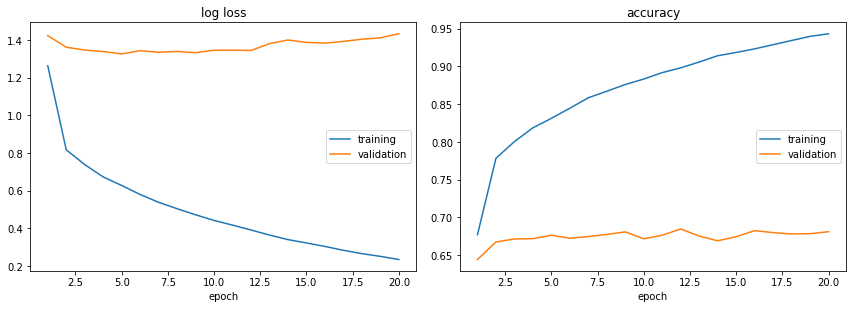

Train Loss: 0.2343 Acc: 0.9430
Val Loss: 1.4338 Acc: 0.6810

Training complete in 53m 42s
Best Validation Accuracy: 0.6846, Epoch: 12


In [64]:
#Train
train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, num_epochs=20)

In [6]:
# model_ft.load_state_dict(torch.load('./models/model_6_epoch.pt'))
# #Test
# test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft)